In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"

import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import corner
import batman
import emcee
import time
from multiprocessing import Pool
from IPython.display import display, Math
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as tck

from exotic_ld import StellarLimbDarkening

import pandas as pd
import pickle

import celerite2
from celerite2 import terms

In [2]:
TIC = 'TIC 66818296' #WASP-17 / TIC 66818296

search_result = lk.search_lightcurve(
    target=TIC,
    mission='TESS', author='SPOC')
print("trying to download")
lc_collection = search_result.download_all()
lc_sector_12 = lc_collection[0].remove_nans()
lc_sector_38 = lc_collection[1].remove_nans()
print("Search done")
print(lc_collection)
lc = lc_collection.stitch(corrector_func=lambda x: x.
                          remove_nans().normalize(unit='unscaled'))
#Sector 12 and sector 38
lc = lc.remove_nans()

trying to download
Search done
LightCurveCollection of 2 objects:
    0: <TessLightCurve LABEL="TIC 66818296" SECTOR=12 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 66818296" SECTOR=38 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [3]:
t = np.array(lc.time.btjd)
flux_data = np.array(lc.flux)
yerrs = np.array(lc.flux_err)

In [4]:
filename = "WASP_17b_flat_samples.p"
with open(filename, "rb") as f:
    flat_samples = pickle.load(f)
f.close()

In [5]:
#batman model
model_T0 = np.percentile(flat_samples[:, 0], 50) #Mid-transit time (Days)
model_Rp = np.percentile(flat_samples[:, 1], 50) #Rp/Rs
model_per = np.percentile(flat_samples[:, 2], 50) #Orbital period (Days)
model_inc = np.percentile(flat_samples[:, 3], 50) #Orbital inclination (Deg)
model_a = np.percentile(flat_samples[:, 4], 50) #a/R*

#GP model
model_sigma = np.percentile(flat_samples[:, 5], 50)
model_rho = np.percentile(flat_samples[:, 6], 50)

prior_Rs = 1.583 #R_sun Southworth et al. 2012

model_params = batman.TransitParams()
model_params.t0 = model_T0
model_params.per = model_per
model_params.rp = model_Rp
model_params.a = model_a
model_params.inc = model_inc
model_params.ecc = 0.0 #Fixed to zero for WASP_17b
model_params.w = 90.
model_params.limb_dark = "quadratic"
model_params.u = [0.20660467695878587, 0.2888055783310062] #Estimated by WASP_17b_ldc.ipynb

m = batman.TransitModel(model_params, t) #Use TESS time series, t
batman_model = m.light_curve(model_params)

In [6]:
filename = "WASP_17b_model_flux.p"

if os.path.exists(filename) == True:
    with open(filename, "rb") as f:
        t_none, model_flux = pickle.load(f)
    f.close()

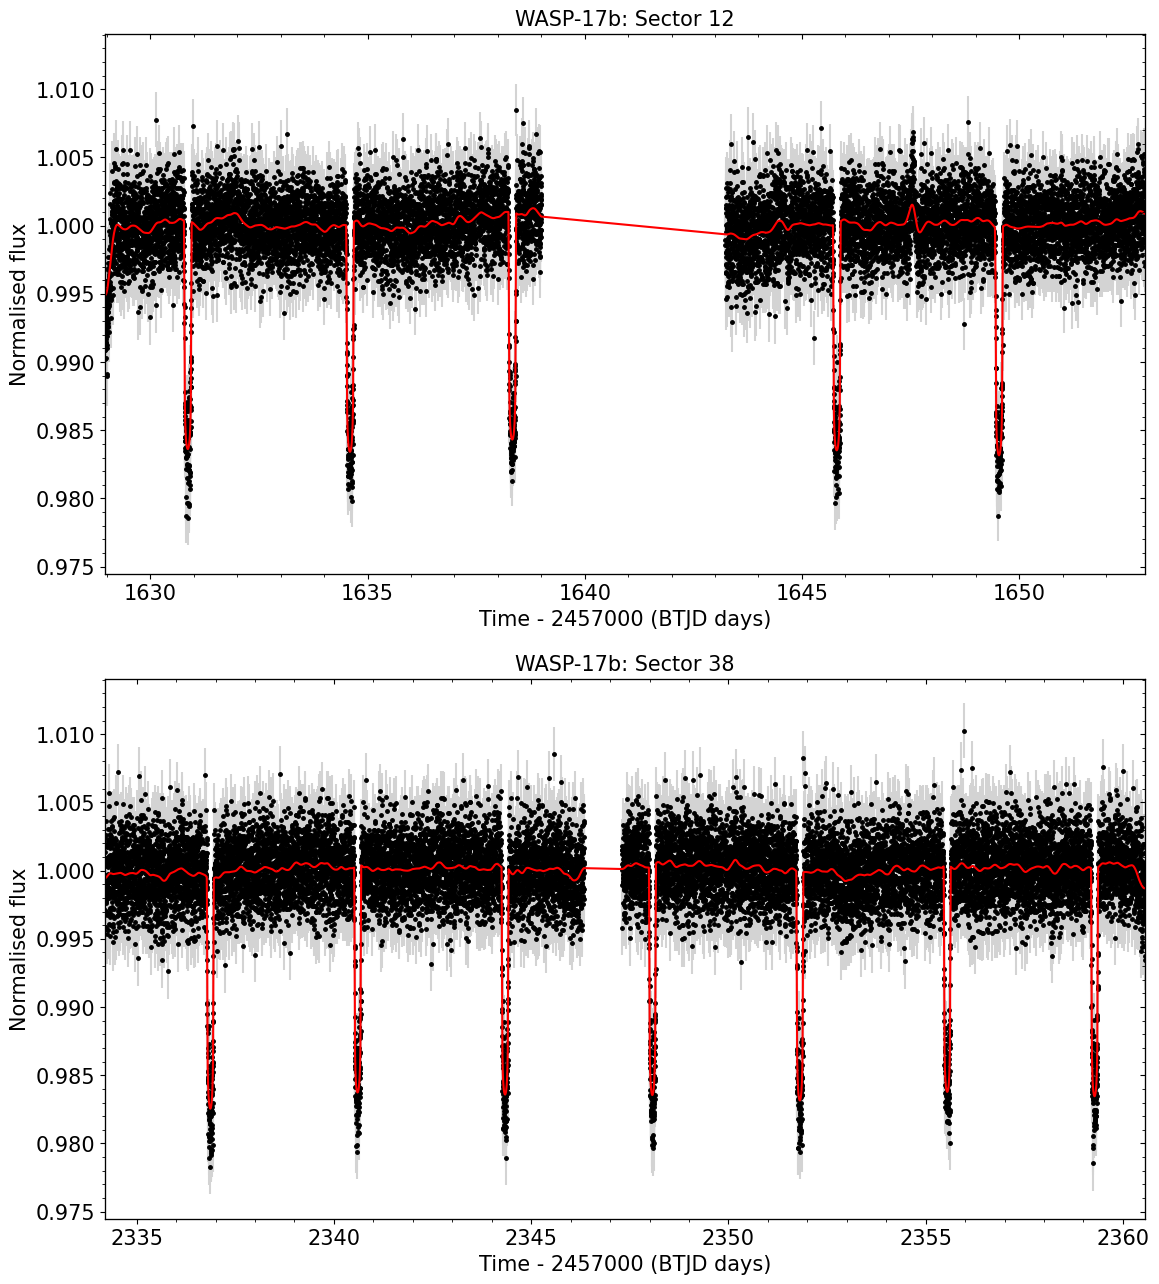

In [12]:
fontsize = 15

#Panel settings
left = 0.1
bottom = 0.1
width = 0.65
height = 0.9
spacing = -height -1.075
w_spacing = 0.075


rect1 = [left, bottom, width, height]
rect3 = [left, bottom+height+spacing, width, height]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_axes(rect1)
ax3 = fig.add_axes(rect3)


"""
WASP-17b: Sector 38
"""
ax1.set_title("WASP-17b: Sector 12", size=fontsize)
ax1.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax1.plot(t, model_flux, color='Red')
ax1.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))
# ax1.set_ylim([0.956, 1.046])
ax1.set_xlabel("Time - 2457000 (BTJD days)", size=fontsize)
ax1.set_ylabel("Normalised flux", size=fontsize)

# Mirror y
ax1y = ax1.twinx()
ax1y.set_ylim(ax1.get_ylim())
ax1y.get_yaxis().set_ticklabels([])
ax1y.tick_params(which="both", direction="in")

# Mirror x
ax1x = ax1.twiny()
ax1x.set_xlim(ax1.get_xlim())
ax1x.get_xaxis().set_ticklabels([])
ax1x.tick_params(which="both", direction="in")

ax1.yaxis.set_tick_params(labelsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=fontsize)

ax1.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1x.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax1.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax1y.yaxis.set_minor_locator(tck.AutoMinorLocator())

"""
WASP-17b: Sector 38
"""
ax3.set_title("WASP-17b: Sector 38", size=fontsize)
ax3.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax3.plot(t, model_flux, color='Red', zorder=10)
ax3.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))
ax3.set_ylim(ax1.get_ylim())
ax3.set_xlabel("Time - 2457000 (BTJD days)", size=fontsize)
ax3.set_ylabel("Normalised flux", size=fontsize)

ax3.yaxis.set_tick_params(labelsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=fontsize)

# Mirror y
ax3y = ax3.twinx()
ax3y.set_ylim(ax3.get_ylim())
ax3y.get_yaxis().set_ticklabels([])
ax3y.tick_params(which="both", direction="in")

# Mirror x
ax3x = ax3.twiny()
ax3x.set_xlim(ax3.get_xlim())
ax3x.get_xaxis().set_ticklabels([])
ax3x.tick_params(which="both", direction="in")

ax3.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax3x.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax3.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax3y.yaxis.set_minor_locator(tck.AutoMinorLocator())


plt.show()

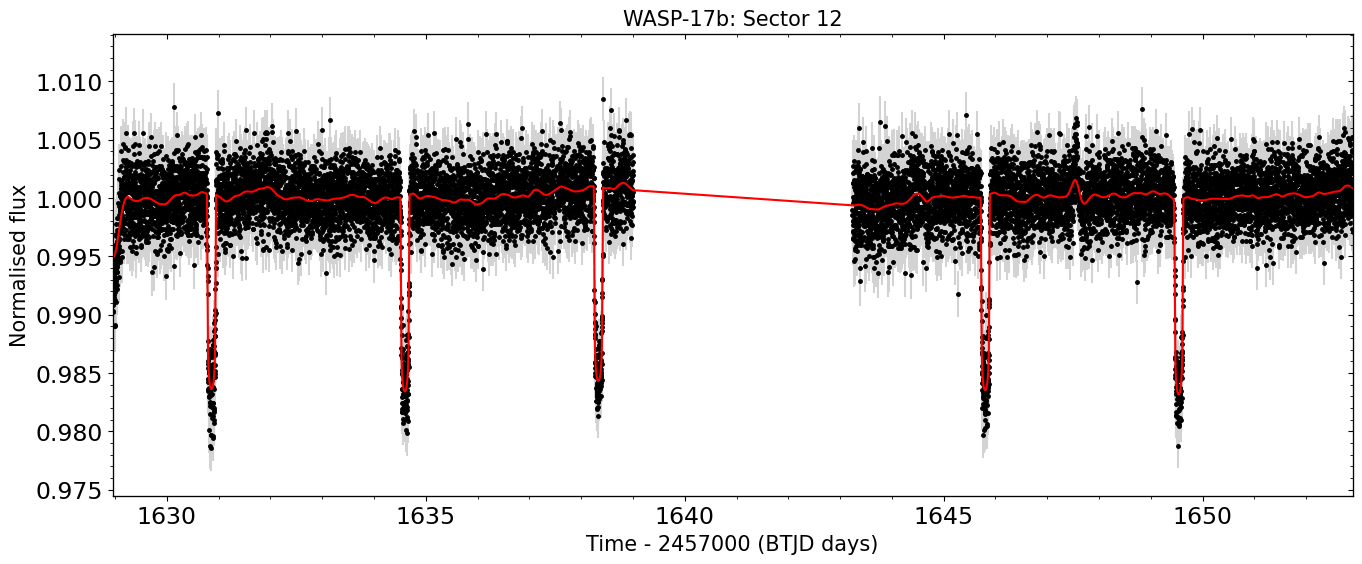

In [11]:
#batman + gp model

fig, ax = plt.subplots(1, figsize=(16,6))

ax.set_title("WASP-17b: Sector 12", size=fontsize)
ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t, model_flux, color='Red')
ax.set_xlim(min(lc_sector_12.time.btjd), max(lc_sector_12.time.btjd))
# ax.set_ylim([0.956, 1.046])
ax.set_xlabel("Time - 2457000 (BTJD days)", size=fontsize)
ax.set_ylabel("Normalised flux", size=fontsize)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()

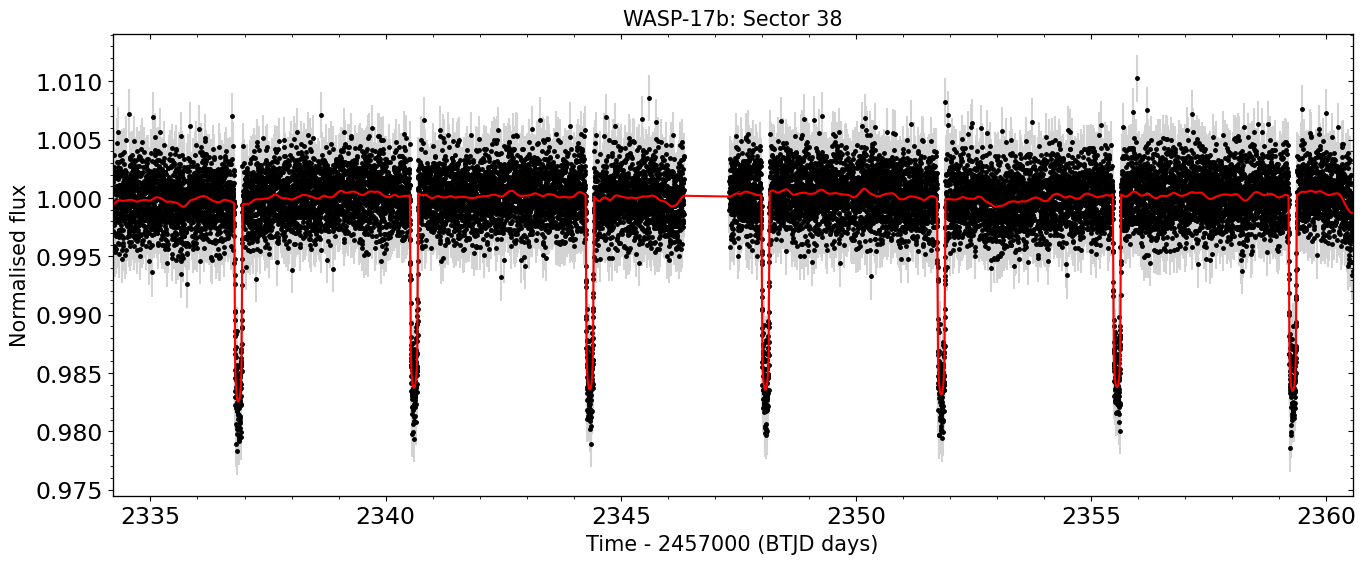

In [10]:
#batman + gp model

fig, ax = plt.subplots(1, figsize=(16,6))

ax.set_title("WASP-17b: Sector 38", size=fontsize)
ax.errorbar(t, flux_data, yerr=yerrs,fmt='.', markersize=5, color='black', ecolor='LightGrey', label="Data", zorder=0) #Black
ax.plot(t, model_flux, color='Red', zorder=10)
ax.set_xlim(min(lc_sector_38.time.btjd), max(lc_sector_38.time.btjd))
# ax.set_ylim(ax1.get_ylim())
ax.set_xlabel("Time - 2457000 (BTJD days)", size=fontsize)
ax.set_ylabel("Normalised flux", size=fontsize)

# Mirror y
axA = ax.twinx()
axA.set_ylim(ax.get_ylim())
axA.get_yaxis().set_ticklabels([])
axA.tick_params(which="both", direction="in")#, labelright=True, labelleft=True)

# Mirror x
axB = ax.twiny()
axB.set_xlim(ax.get_xlim())
axB.get_xaxis().set_ticklabels([])
axB.tick_params(which="both", direction="in")

ax.xaxis.set_tick_params(labelsize=17)
ax.yaxis.set_tick_params(labelsize=17)

#Enabling Minor ticks
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
axB.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
axA.yaxis.set_minor_locator(tck.AutoMinorLocator())

plt.show()